In [1]:
!pip install telethon pandas matplotlib seaborn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for telethon: filename=Telethon-1.36.0-py3-none-any.whl size=680908 sha256=670149cc29257c0a8e0af517f57e42bd78bf57ee12a42d3aaa1cee3136430739
  Stored in directory: c:\users\nasty\appdata\local\pip\cache\wheels\0b\1f\33\53b241dd71631510b2977dfed11db2093af734560ffaa42984
  Created wheel for pyaes: filename=pyaes-1.6.1-py3-none-any.whl size=26363 sha256=afbf8bfec932f981fb951575044c85fbea769351d5053e5c84f6b88d90d3d477
  Stored in directory: c:\users\nasty\appdata\local\pip\cache\wheels\33\13\e9\ef9894385084d8e4fab38f5f83afda49a3d593d8afc907c8fd
Successfully built telethon pyaes


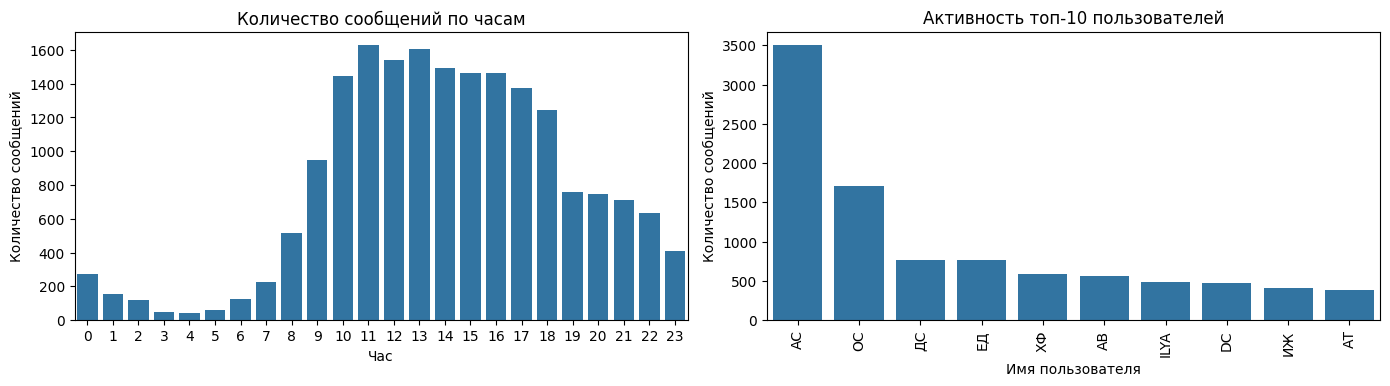

In [19]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Путь к папке с файлами
folder_path = 'C:/Users/nasty/Downloads/Telegram Desktop/ChatExport_2024-06-17'

# Инициализация пустого списка для хранения сообщений
all_messages = []

# Регулярные выражения для извлечения данных
date_pattern = re.compile(r'(\d{1,2} [а-яА-Яa-zA-Z]+ \d{4})')
time_pattern = re.compile(r'(\d{2}:\d{2})')
sender_pattern = re.compile(r'^[A-ZА-ЯЁ]{2,}$')

# Словарь для перевода названий месяцев на числовые значения
months = {
    'января': '01', 'февраля': '02', 'марта': '03', 'апреля': '04', 'мая': '05', 'июня': '06',
    'июля': '07', 'августа': '08', 'сентября': '09', 'октября': '10', 'ноября': '11', 'декабря': '12',
    'January': '01', 'February': '02', 'March': '03', 'April': '04', 'May': '05', 'June': '06',
    'July': '07', 'August': '08', 'September': '09', 'October': '10', 'November': '11', 'December': '12'
}

# Функция для очистки строки от нежелательных символов
def clean_string(s):
    return re.sub(r'[^\w\s]', '', s)

# Функция для проверки, является ли строка датой
def is_valid_date(date_str):
    return bool(re.match(r'\d{1,2} [а-яА-Яa-zA-Z]+ \d{4}', date_str))

# Функция для преобразования даты в формат datetime
def parse_date(date_str):
    if not is_valid_date(date_str):
        print(f"Invalid date format: {date_str}")
        return None

    original_date_str = date_str  # Сохранение оригинальной строки для отладки
    for ru, en in months.items():
        date_str = re.sub(r'\b' + re.escape(ru) + r'\b', en, date_str)
    date_str = clean_string(date_str)
    try:
        return datetime.strptime(date_str, '%d %m %Y')
    except ValueError:
        return None

# Чтение всех файлов в папке
for filename in os.listdir(folder_path):
    if filename.startswith('messages') and filename.endswith('.html'):  # Убедитесь, что обрабатываются только нужные файлы
        filepath = os.path.join(folder_path, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            current_date = None
            current_time = None
            current_sender = None

            for line in lines:
                line = line.strip()
                # Поиск даты
                date_match = date_pattern.search(line)
                if date_match:
                    current_date = parse_date(date_match.group(1))
                    continue

                # Поиск времени
                time_match = time_pattern.search(line)
                if time_match:
                    current_time = time_match.group(1)
                    continue

                # Поиск отправителя
                sender_match = sender_pattern.search(line)
                if sender_match:
                    current_sender = sender_match.group(0)
                    continue

                # Если есть текущие дата, время и отправитель, то это сообщение
                if current_date and current_time and current_sender and line:
                    datetime_str = f"{current_date.strftime('%Y-%m-%d')} {current_time}"
                    all_messages.append({
                        'datetime': datetime_str,
                        'sender': current_sender,
                        'message': line
                    })
                    current_time = None  # Сброс времени для следующего сообщения
                    current_sender = None  # Сброс отправителя для следующего сообщения

# Преобразование в DataFrame
df = pd.DataFrame(all_messages)

# Преобразование колонки datetime в формат datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M', errors='coerce')
df.dropna(subset=['datetime'], inplace=True)  # Удалить строки с некорректными датами

# Метрика 1: Количество сообщений по часам
df['hour'] = df['datetime'].dt.hour
hourly_messages = df.groupby('hour').size()

# Метрика 2: Активность пользователей (количество сообщений от каждого пользователя)
user_activity = df['sender'].value_counts()

# Выбор топ N пользователей
N = 10  # Выберите количество топ пользователей для отображения
top_users = user_activity.head(N)

# Фильтрация данных для отображения только топ N пользователей
top_user_messages = df[df['sender'].isin(top_users.index)]

# Визуализация метрик
plt.figure(figsize=(14, 7))

plt.subplot(2, 2, 1)
sns.barplot(x=hourly_messages.index, y=hourly_messages.values)
plt.title('Количество сообщений по часам')
plt.xlabel('Час')
plt.ylabel('Количество сообщений')

plt.subplot(2, 2, 2)
sns.barplot(x=top_users.index, y=top_users.values)
plt.title(f'Активность топ-{N} пользователей')
plt.xlabel('Имя пользователя')
plt.ylabel('Количество сообщений')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()